$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|} $
$\newcommand{\au}{\hat{a}^\dagger}$
$\newcommand{\ad}{\hat{a}}$
$\newcommand{\bu}{\hat{b}^\dagger}$
$\newcommand{\bd}{\hat{b}}$
# Cat state encoding
The main goal is to find control pulses which will realise the state transfer:
$$ \underbrace{(c_0\ket{0} + c_1\ket{1})}_{\text{Qubit}}\underbrace{\ket{0}}_{\text{Cavity}} \rightarrow \ket{0}(c_0\ket{C_0} + c_1 \ket{C_1}) $$
where $ \ket{C_0} \propto \ket{-\alpha} + \ket{\alpha} $ is the logical zero and $ \ket{C_1} \propto \ket{-i\alpha} + \ket{i\alpha} $ is the logical one. The method is to optimise such that the six cardinal points on the Bloch sphere realise these cavity cat states and puts the qubit to the ground state.

In [313]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [314]:
from qutip import identity, sigmax, sigmay, sigmaz, sigmam, sigmap, tensor, projection, create, destroy, displace
from qutip import Qobj, basis, coherent, mesolve, fock
from qutip.superoperator import liouvillian, sprepost
from qutip.qip import hadamard_transform
from qutip.visualization import plot_wigner, plot_wigner_fock_distribution
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
#log_level = logging.INFO
log_level = logging.WARN
#QuTiP control modules
import qutip.control.pulseoptim as cpo

file_name = 'Test1'
pi = np.pi

# Physics
## Hamiltonian
$$ \hat{H} =  \underbrace{(\omega_a - \chi_{sa}\au\ad)\bu\bd}_{\text{Storage-ancilla coupling}} +\, \omega_s\au\ad  \,-\, \frac{K_s}{2}\au{}^2\ad{}^2 \,-\, \frac{K_a}{2}\bu{}^2\bd{}^2 \,+\, \underbrace{\epsilon_a(t)\bu + \epsilon_a^*(t)\bd}_{\text{Qubit drive}} \,+\, \underbrace{\epsilon_s(t)\au + \epsilon_s^*(t)\ad}_{\text{Res drive}} $$

$$ \bu\bd = \ket{1}\bra{1} = \sigma_-\sigma_+ $$

In [315]:
N = 15 # Hilbert space size
alpha = 2

Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Si = identity(2)
Ri = identity(N)
Sm = tensor(sigmam(), Ri)
Sp = tensor(sigmap(), Ri) 
a  = tensor(Si, destroy(N))
b  = Sp



# Hamiltonian - RWA JC, qubit-storage coupling
w_q = 2*pi*6.2815    # Energy of the 2-level system.
w_r = 2*pi*8.3056    # Resonator freq
X_qr= 2*pi*1.97e0    # qubit-storage coupling strength
K_r   = 0.05#.05    # Kerr res
K_q   = 0.05#.05    # Kerr qubit
gamma = 0.05   # Qubit dissipation
eps = 10*(1+1j)

H0 = ( w_r*a.dag()*a
    +  w_q*b.dag()*b
    - X_qr * a.dag()*a * b.dag()*b
    - K_r/2 * a.dag()**2 * a**2 - K_q/2 * b.dag()**2 * b**2  )
     #+ eps*a.dag() + np.conj(eps)*a + eps*b.dag() + np.conj(eps)*b)

#H0 = w_r * a.dag() * a + w_q * b.dag() * b + X_qr * (a.dag() * b + a * b.dag())
#H0 = w_r * a.dag() * a + w_q * Sm.dag() * Sm + X_qr * (a.dag()*a * b.dag()*b)

#Amplitude damping
#Damping rate:
#gamma = 0.1
#L0 = liouvillian(H, [np.sqrt(gamma)*Sm])

#sigma X control
#LC_x = liouvillian(Sx)
#sigma Y control
#LC_y = liouvillian(Sy)
#sigma Z control
#LC_z = liouvillian(Sz)

#Drift
#drift = L0
drift = H0
#Controls - 

ctrls = [a.dag(), a, b.dag(), b]

#ctrls = [tensor(Sx,Ri), tensor(Sy, Ri), tensor(Sz, Ri), tensor(Si, a.dag()), tensor(Si, a)]

# Starting state


#N_alpha = 1/(2*(1+np.exp(-2*abs(alpha)^2)))
logical_0 = (coherent(N, alpha) + coherent(N,-alpha)).unit()
logical_1 = (coherent(N, alpha*1j) + coherent(N,-alpha*1j)).unit()
phi = tensor(basis(2,1), logical_0)
#print(phi)
#print(res_targ_0)
# target for map evolution
phi_targ = tensor(basis(2,0), logical_1)

# System evolution
Test to see if the system is setup correctly

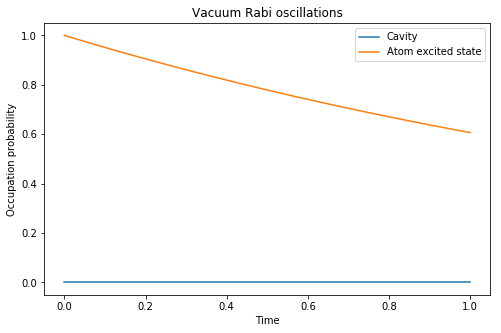

In [316]:
psi0 = tensor(basis(2,1), basis(N,0))
tlist = np.linspace(0,1,100)
rate = np.sqrt(10*gamma) * b
output = mesolve(H0, psi0, tlist, [rate], [a.dag()*a, b.dag()*b])
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(tlist, output.expect[0], label="Cavity")
ax.plot(tlist, output.expect[1], label="Atom excited state")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Vacuum Rabi oscillations');

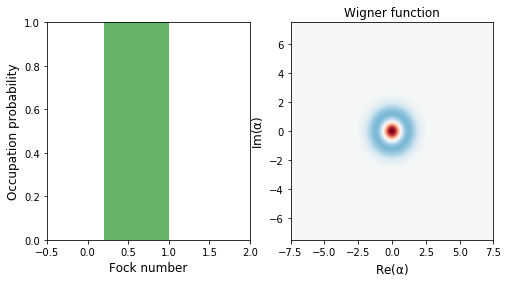

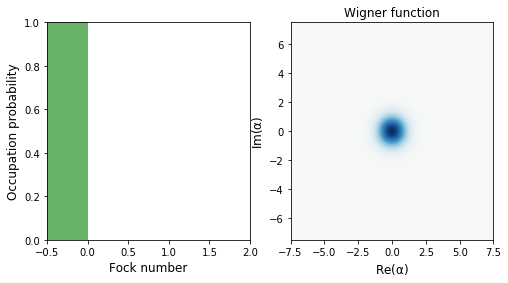

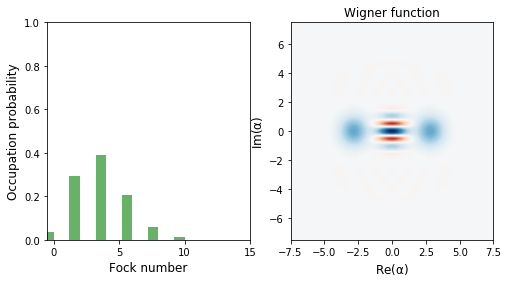

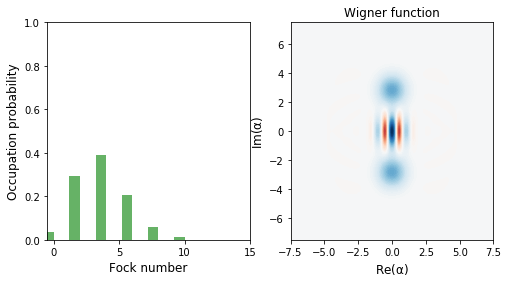

In [317]:
def plot_wigners(states):
    #f = plt.figure(figsize=(6*len(states), 6))
    for i, state in enumerate(states):
        #a = f.add_subplot(1,len(states),i+1)
        plot_wigner_fock_distribution(state,)#fig=f,ax = a)
        #a.axis('equal')

states = [phi, phi_targ]
qubit_states = [s.ptrace(0) for s in states]
res_states = [s.ptrace(1) for s in states]
plot_wigners(qubit_states)
plot_wigners(res_states)


In [318]:
# Time slot length
l_ts = 1e-5
# Time allowed for the evolution (sec)
evo_time = 5000e-5
# Number of time slots
n_ts = int(evo_time//l_ts + 1)

In [319]:
# Fidelity error target
fid_err_targ = 1e-5
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 60
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'LIN'
#Set to None to suppress output files
#f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)
f_ext = None

In [320]:
result = cpo.optimize_pulse(drift, ctrls, phi, phi_targ, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                out_file_ext=f_ext, init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:01:05.230797
Wall time computing Hamiltonians: 0:00:01.161184 (1.78%)
Wall time computing propagators: 0:00:58.439894 (89.59%)
Wall time computing forward propagation: 0:00:00.105572 (0.16%)
Wall time computing onward propagation: 0:00:00.430156 (0.66%)
Wall time computing gradient: 0:00:03.022194 (4.63%)

**** Iterations and function calls ****
Number of iterations: 1
Number of fidelity function calls: 4
Number of times fidelity is computed: 4
Number of gradient function calls: 4
Number of times gradients are computed: 4
Number of times timeslot evolution is recomputed: 4

**** Control amplitudes ****
Number of control amplitude updates: 3
Mean number of updates per iteration: 3.0
Number of timeslot values changed: 15000
Mean number of timeslot changes per update: 5000.0
Number of amplitude values changed: 60000
Mean number of amplit

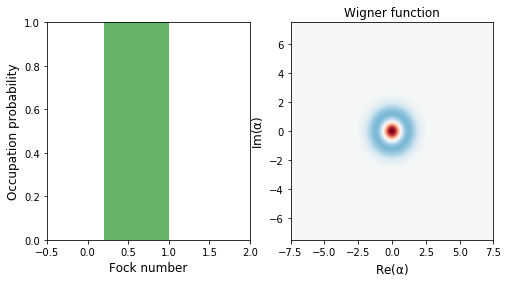

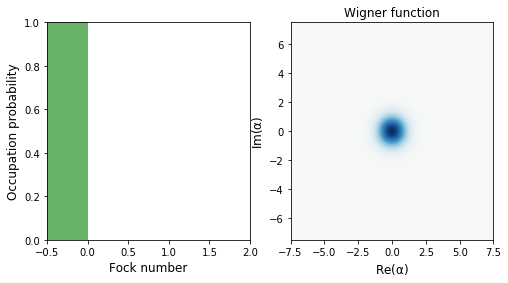

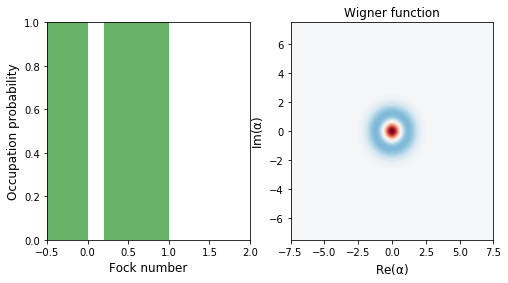

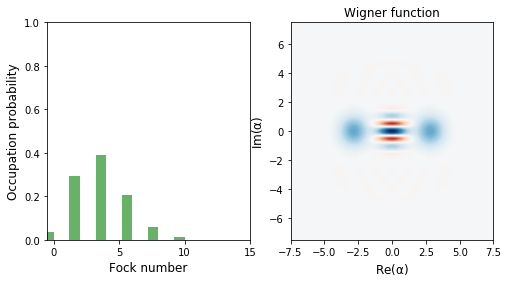

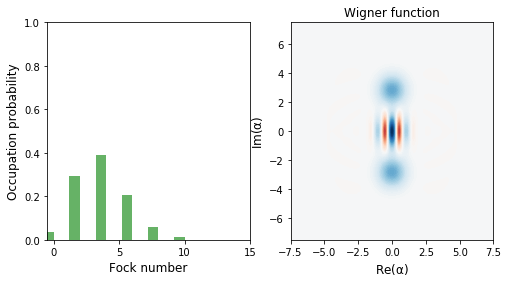

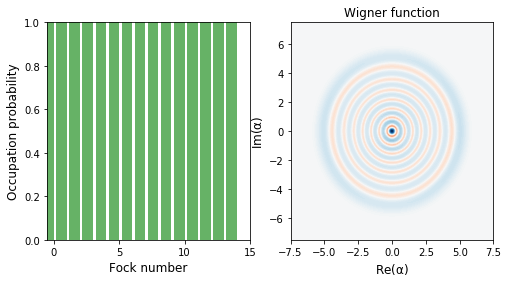

In [321]:
states = [phi, phi_targ, result.evo_full_final]
qubit_states = [s.ptrace(0) for s in states]
res_states = [s.ptrace(1) for s in states]
plot_wigners(qubit_states + res_states)

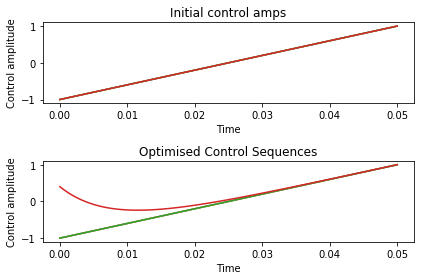

In [322]:
def plot_control_pulses(result):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(2, 1, 1)
    ax1.set_title("Initial control amps")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Control amplitude")
    ax2 = fig1.add_subplot(2, 1, 2)
    ax2.set_title("Optimised Control Sequences")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Control amplitude")
    for i in range(len(ctrls)):
        ax1.step(result.time, 
                 np.hstack((result.initial_amps[:, i], result.initial_amps[-1, i])), 
                 where='post')
        ax2.step(result.time, 
         np.hstack((result.final_amps[:, i], result.final_amps[-1, i])), 
         where='post')
    fig1.tight_layout()
    
plot_control_pulses(result)